# Recurrent Neural Networks

A major characteristic of all neural networks, such as densely connected networks and convnets, is that they have no memory. Each input shown to them is processed independently, with no state kept in between inputs. With such networks, in order to process a sequence or a temporal series of data points, we have to show the entire sequence to the network at once: turn it into a single data point. For instance, this is what we did in the IMDB example: an entire movie review was transformed into a single large vector and processed in one go. Such networks are called **feedforward networks**.

In contrast, as we’re reading the present sentence, we’re processing it word by word—or rather, eye saccade by eye saccade—while keeping memories of what came before; this gives us a fluid representation of the meaning conveyed by this sentence. Biological intelligence processes information incrementally while maintaining an internal model of what it’s processing, built from past information and constantly updated as new information comes in.

A **recurrent neural network (RNN)** adopts the same principle, albeit in an extremely simplified version: it processes sequences by iterating through the sequence elements and maintaining a **state** containing information relative
to what it has seen so far. In effect, an RNN is a type of neural network that has an internal loop. The state of the RNN is reset between processing two different, independent sequences (such as two different IMDB reviews), so we still consider one sequence a single data point: a single input to the network. What changes is that this data point is no longer processed in a single step; rather, the network internally loops over sequence elements.
![capture](https://user-images.githubusercontent.com/13174586/50203219-c3622180-0386-11e9-8d60-854211ce55e1.JPG)

To make these notions of **loop and state** clear, let’s implement the forward pass of a toy RNN in Numpy. This RNN takes as input a sequence of vectors, which we’ll encode as a 2D tensor of size ```(timesteps, input_features)```. It loops over timesteps, and at each timestep, it considers its current state at t and the input at t (of shape ```(input_features,)```, and combines them to obtain the output at t. We’ll then set the state for the next step to be this previous output. For the first timestep, the previous output isn’t defined; hence, there is no current state. So, we’ll initialize the state as an all zero
vector called the **initial state** of the network.

### Pseudocode RNN

In [ ]:
state_t=0 #state as t
for input_t in input_sequence: #Iterates of sequence of elements
    output_t= f(input_t, state_t)
    state_t= output_t #The previous output becomes the state for the next iteration.

We can even flesh out the function f: the transformation of the input and state into an output will be parameterized by two matrices, **```W```** and **```U```**, and a **```bias```** vector. It’s similar to the transformation operated by a densely connected layer in a feedforward network.

### More Detailed Pseudocode for The RNN

In [ ]:
state_t=0
for input_t in input_sequence:
    output_t= activation(dot(W, input_t)+dot(U,state_t)+bias)
    sate_t= output_t

To make these notions absolutely unambiguous, let’s write a naive Numpy implementation of the forward pass of the simple RNN.

### Numpy Implementation of A Simple RNN

In [8]:
import numpy as np

timesteps=100 #Number of timesteps in the input sequence
input_features= 32 #Dimensionality of the input feature space
output_features=64 #Dimensionality of the output feature space

inputs= np.random.random((timesteps, input_features)) #Input data: random noise for example

state_t= np.zeros((output_features,)) #Initial state: an all-zero vector

W= np.random.random((output_features, input_features))  #Creates random
U= np.random.random((output_features, output_features)) #weight matrices
b= np.random.random((output_features,))

successive_outputs=[]
for input_t in inputs: #input_t is a vector of shape (input_features,)
    output_t= np.tanh(np.dot(W, input_t)+np.dot(U, state_t)+b) #Combines the input with the current state 
                                                            #(the previous output) to obtain the current output
    
    successive_outputs.append(output_t) #Stores this output in a list
    state_t= output_t #Updates the state of the network for the next timestep
    
    
final_output_sequence= np.concatenate(successive_outputs, axis=0) #The final output is a 2D tensor of 
                                                                    #shape (timesteps, output_features).                

Easy enough: in summary, an RNN is a ```for``` loop that reuses quantities computed during the previous iteration of the loop, nothing more. Of course, there are many different RNNs fitting this definition that we could build—this example is one of the simplest RNN formulations. RNNs are characterized by their step function, such as the following function in this case

```output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)```

![capture](https://user-images.githubusercontent.com/13174586/50208024-227b6280-0396-11e9-8955-a83ab7fc92af.JPG)

> **NOTE** In this example, the final output is a 2D tensor of shape ```(timesteps, output_features)```, where each timestep is the output of the loop at time t. Each timestep t in the output tensor contains information about timesteps 0 to t in the input sequence—about the entire past. For this reason, in many cases, we don’t need this full sequence of outputs; we just need the last output (```output_t``` at the end of the loop), because it already contains information about the entire sequence.

### Recurrent Layer in Keras

The process we just naively implemented in Numpy corresponds to an actual Keras layer—the ```SimpleRNN``` layer:<br/>
```from keras.layers import SimpleRNN```

There is one minor difference: ```SimpleRNN``` processes batches of sequences, like all other Keras layers, not a single sequence as in the Numpy example. This means it takes inputs of shape ```(batch_size, timesteps, input_features)```, rather than ```(timesteps, input_features)```. 

Like all recurrent layers in Keras, ```SimpleRNN``` can be run in two different modes: it can return either the full sequences of successive outputs for each timestep (a 3D tensor of shape ```(batch_size, timesteps, output_features)```) or only the last output for each input sequence (a 2D tensor of shape ```(batch_size, output_features)```). These two modes are controlled by the return_sequences constructor argument. Let’s look at an example that uses SimpleRNN and returns only the output at the last timestep:

In [1]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model= Sequential()
model.add(Embedding(1000, 32))
model.add(SimpleRNN(32))

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 34,080
Trainable params: 34,080
Non-trainable params: 0
_________________________________________________________________


The following example returns the full state sequence:

In [2]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model= Sequential()
model.add(Embedding(1000,32))
model.add(SimpleRNN(32, return_sequences=True))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 34,080
Trainable params: 34,080
Non-trainable params: 0
_________________________________________________________________


It’s sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. In such a setup, we have to get all of the intermediate layers to return full sequence of outputs:

In [3]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model=Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32)) #Last layer only returns the last output

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now, let’s use such a model on the IMDB movie-review-classification problem. First, preprocess the data.

### Prepare The IMDB Data

In [20]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features=10000
maxlen=1000 #Cuts off texts after this many words (among the max_features most common words)
batch_size=32


print('Loading data...')
(input_train, y_train), (input_test, y_test)= imdb.load_data(num_words=max_features)

print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad Sequences (sample x time)')
input_train= sequence.pad_sequences(input_train, maxlen=maxlen)
input_test= sequence.pad_sequences(input_test, maxlen=maxlen)

print('Padded input_train shape', input_train.shape)
print('Padded input_test shape', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad Sequences (sample x time)
Padded input_train shape (25000, 1000)
Padded input_test shape (25000, 1000)


Let’s train a simple recurrent network using an ```Embedding``` layer and a ```SimpleRNN``` layer.

### Train The Model With Embedding and SimpleRNN Layers

In [21]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Embedding

model=Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [23]:
history= model.fit(input_train, y_train, epochs=30, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 42s 2ms/step - loss: 0.6042 - acc: 0.6600 - val_loss: 0.5342 - val_acc: 0.7282
Epoch 2/30
20000/20000 [==============================] - 42s 2ms/step - loss: 0.4007 - acc: 0.8303 - val_loss: 0.4178 - val_acc: 0.8178
Epoch 3/30
20000/20000 [==============================] - 43s 2ms/step - loss: 0.2978 - acc: 0.8805 - val_loss: 0.4855 - val_acc: 0.7612
Epoch 4/30
20000/20000 [==============================] - 42s 2ms/step - loss: 0.2463 - acc: 0.9052 - val_loss: 0.3695 - val_acc: 0.8496
Epoch 5/30
20000/20000 [==============================] - 42s 2ms/step - loss: 0.1859 - acc: 0.9295 - val_loss: 0.3908 - val_acc: 0.8582
Epoch 6/30
20000/20000 [==============================] - 42s 2ms/step - loss: 0.1646 - acc: 0.9406 - val_loss: 0.4056 - val_acc: 0.8510
Epoch 7/30
20000/20000 [==============================] - 42s 2ms/step - loss: 0.1040 - acc: 0.9647 - val_loss: 0.4147 - val_acc:

In [24]:
import matplotlib.pyplot as plt

acc= history.history['acc']
val_acc= history.history['val_acc']
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs= range(1,len(acc)+1)

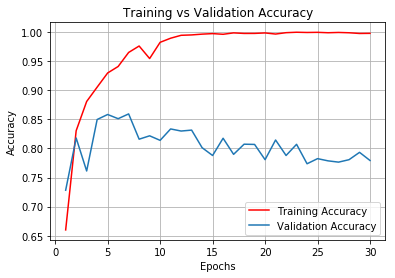

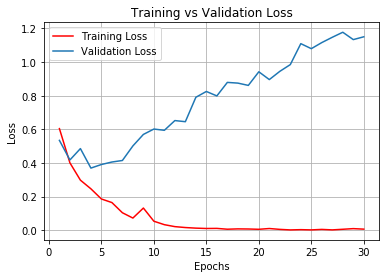

In [25]:
plt.plot(epochs, acc, color='red', label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

plt.plot(epochs, loss, color='red', label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

Unfortunately, this small recurrent network doesn’t perform well compared to this baseline (only 80% validation accuracy). Part of the problem is that our inputs only consider the first 500 words(later changed it to 1000 and achieved an validation accuracy of ~86%), rather than full sequences—hence, the RNN has access to less information than the earlier baseline model. The remainder of the problem is that SimpleRNN isn’t good at processing long sequences, such as text.

Other types of recurrent layers perform much better. Let’s look at some more advanced layers.

### LSTM and GRU Layers
```SimpleRNN``` isn’t the only recurrent layer available in Keras. There are two others: ```LSTM``` and ```GRU```. In practice, we’ll always use one of these, because SimpleRNN is generally too simplistic to be of real use. SimpleRNN has a major issue: although it should theoretically be able to retain at time t information about inputs seen many timesteps before, in practice, such long-term dependencies are impossible to learn. This is due to the ***vanishing gradient problem**, an effect that is similar to what is observed with non-recurrent networks (feedforward networks) that are many layers deep: as we keep adding layers to a network, the network eventually becomes untrainable. The LSTM and GRU layers are designed to solve this problem.

Let’s consider the LSTM layer. The underlying ***Long Short-Term Memory (LSTM)*** algorithm was developed by Hochreiter and Schmidhuber in 1997; it was the culmination of their research on the vanishing gradient problem.

This layer is a variant of the SimpleRNN layer we already know about; it adds a way to carry information across many timesteps. Imagine a conveyor belt running parallel to the sequence we’re processing. Information from the sequence can jump onto the
conveyor belt at any point, be transported to a later timestep, and jump off, intact, when we need it. This is essentially what LSTM does: it saves information for later, thus preventing older signals from gradually vanishing during processing.

To understand this in detail, let’s start from the SimpleRNN cell. Because we’ll have a lot of weight matrices, index the **```W```** and **```U```** matrices in the cell with the letter `o` ( **```Wo```** and **```Uo```**) for output.

![capture](https://user-images.githubusercontent.com/13174586/50213920-059a5b80-03a5-11e9-9ab0-5f5c23561edd.JPG)

Let’s add to this picture an additional data flow that carries information across timesteps. Call its values at different timesteps ``Ct``, where `C` stands for `carry`. This information will have the following impact on the cell: it will be combined with the input connection and the recurrent connection (via a dense transformation: a dot product with a weight matrix followed by a bias add and the application of an activation function), and it will affect the state being sent to the next timestep (via an activation function an a multiplication operation). Conceptually, the carry dataflow is a way to modulate the next output and the next state. Simple so far.

![capture](https://user-images.githubusercontent.com/13174586/50214899-7b9fc200-03a7-11e9-9eb7-60916e27ca56.JPG)

Now the subtlety: the way the next value of the carry dataflow is computed. It involves three distinct transformations. All three have the form of a SimpleRNN cell:

```y = activation(dot(state_t, U) + dot(input_t, W) + b)```

But all three transformations have their own weight matrices, which we’ll index with the letters i, f, and k. Here’s what we have so far.

### Pseudocode Details of The LSTM Architecture (1/2)

```output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(C_t, Vo) + bo)```<br/>
```i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)```<br/>
```f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)```<br/>
```k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)```<br/>

We obtain the new carry state (the next `c_t`) by combining ```i_t```, `f_t`, and `k_t`.

```c_t+1 = i_t * k_t + c_t * f_t```

![capture](https://user-images.githubusercontent.com/13174586/50215399-e30a4180-03a8-11e9-8447-ac729e10bd6b.JPG)

If we want to get philosophical, we can interpret what each of these operations is meant to do. For instance, we can say that multiplying `c_t` and `f_t` is a way to deliberately **forget irrelevant information** in the carry dataflow. Meanwhile, `i_t` and `k_t` provide information about the present, updating the carry track with new information. But at the end of the day, these interpretations don’t mean much, because what these operations actually do is determined by the contents of the weights parameterizing them; and the weights are learned in an end-to-end fashion, starting over with each training round, making it impossible to credit this or that operation with a specific purpose. The specification of an RNN cell (as just described) determines our hypothesis space—the space in which we’ll search for a good model configuration during training—but it doesn’t determine what the cell does; that is up to the cell weights. The same cell with different weights can be doing very different things. So the combination of operations making up an RNN cell is better interpreted as a set of **constraints** on our search, not as a **design** in an engineering sense.

To a researcher, it seems that the choice of such constraints—the question of how to implement RNN cells—is better left to optimization algorithms (like genetic algorithms or reinforcement learning processes) than to human engineers. And in the future, that’s how we’ll build networks. In summary: we don’t need to understand anything about the specific architecture of an LSTM cell; as a human, it shouldn’t be our job to understand it. We should just keep in mind what the LSTM cell is meant to do: allow past information to be reinjected at a later time, thus fighting the vanishing-gradient problem.

### A Concrete LSTM Example in Keras
Now let’s switch to more practical concerns: we’ll set up a model using an LSTM layer and train it on the IMDB data. The network is similar to the one with SimpleRNN that was just presented. We only specify the output dimensionality of the LSTM layer; leave every other argument (there are many) at the Keras defaults. Keras has good defaults, and things will almost always “just work” without us having to spend time tuning parameters by hand.

### LSTM Layer in Keras

In [30]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense

model= Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [32]:
history= model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 194s 10ms/step - loss: 0.5280 - acc: 0.7533 - val_loss: 0.3997 - val_acc: 0.8252
Epoch 2/10
20000/20000 [==============================] - 191s 10ms/step - loss: 0.3132 - acc: 0.8782 - val_loss: 0.3559 - val_acc: 0.8476
Epoch 3/10
20000/20000 [==============================] - 186s 9ms/step - loss: 0.2416 - acc: 0.9102 - val_loss: 0.3331 - val_acc: 0.8756
Epoch 4/10
20000/20000 [==============================] - 187s 9ms/step - loss: 0.2064 - acc: 0.9245 - val_loss: 0.2865 - val_acc: 0.8850
Epoch 5/10
20000/20000 [==============================] - 188s 9ms/step - loss: 0.1837 - acc: 0.9353 - val_loss: 0.4000 - val_acc: 0.8310
Epoch 6/10
20000/20000 [==============================] - 189s 9ms/step - loss: 0.1645 - acc: 0.9419 - val_loss: 0.3034 - val_acc: 0.8882
Epoch 7/10
20000/20000 [==============================] - 187s 9ms/step - loss: 0.1509 - acc: 0.9485 - val_loss: 0.5006 -

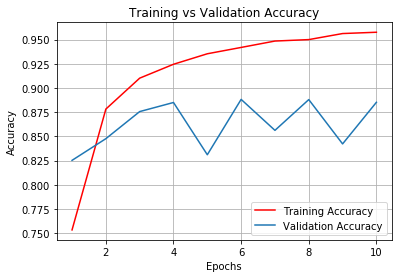

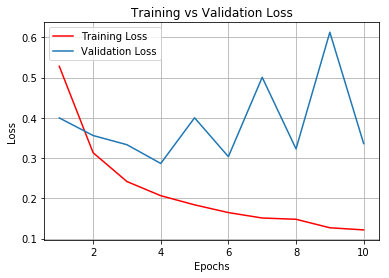

In [33]:
acc= history.history['acc']
val_acc= history.history['val_acc']

loss= history.history['loss']
val_loss= history.history['val_loss']

epochs=range(1, len(acc)+1)

import matplotlib.pyplot as plt

plt.plot(epochs, acc, color='red', label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


plt.plot(epochs, loss, color='red', label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

This time, we achieve up to ~88% validation accuracy. Not bad: certainly much better than the SimpleRNN network—that’s largely because LSTM suffers much less from the vanishing-gradient problem—and slightly better than the fully connected approach, even though we’re looking at less data. We’re truncating sequences after 1000 timesteps.

But this result isn’t groundbreaking for such a computationally intensive approach. Why isn’t LSTM performing better? One reason is that we made no effort to tune hyperparameters such as the embeddings dimensionality or the LSTM output dimensionality. Another may be lack of regularization. But honestly, the primary reason is that analyzing the global, long-term structure of the reviews (what LSTM is good at) isn’t helpful for a sentiment-analysis problem. Such a basic problem is well solved by looking at what words occur in each review, and at what frequency. That’s what the first fully connected approach looked at. But there are far more difficult naturallanguage- processing problems out there, where the strength of LSTM will become apparent: in particular, question-answering and machine translation.